In [9]:
import os
import sys
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(r"D:\Courses\Pattern Recognition\UB-CSE-555\data_preprocess")

from dataset_loader import data_loader, GlossKeypointDataset

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [ ]:
train_loader, test_loader, val_loader = data_loader(batch_size=128)
dataset = GlossKeypointDataset()
num_classes = len(dataset.gloss_to_index)

print("Number of classes:", num_classes)
print("Sample classes:", list(dataset.gloss_to_index.items())[:5])

# print("Training data")
# for i, (gloss, keypoints) in enumerate(train_loader):
#     print(f"Step {i}, Gloss: {gloss}, Keypoints: {keypoints}")
#     break



Total dataset size: 347
Number of classes: 30
Sample classes: [('accident', 0), ('bed', 1), ('before', 2), ('bowling', 3), ('candy', 4)]


In [5]:
print("Training data")
for i, (gloss, keypoints) in enumerate(train_loader):
    print(f"Step {i}, Gloss: {gloss}, Keypoints: {keypoints}")
    break


Training data
Step 0, Gloss: tensor([ 4, 18,  4, 20,  9, 13, 15, 23, 22,  6,  7, 13, 12, 15, 18, 20, 23, 13,
        25, 17,  5, 14, 23, 10, 23,  4, 10,  7, 11, 15,  6, 19, 17,  9, 26,  8,
        15, 27, 22, 16, 21, 26, 21, 21, 17, 27, 20,  7, 24, 11, 14, 22, 12,  4,
         2,  5,  6, 22,  7,  8, 13, 16,  5,  4, 21, 17,  7, 27, 14, 10, 14, 19,
        26, 24, 22, 24, 15, 25,  4, 25, 27, 18, 18, 24, 10, 16, 12, 20, 25, 12,
         8, 21, 22, 19, 24, 27, 12,  8, 20,  9, 18, 12, 23, 16,  3, 12,  9, 16,
        13, 21, 26, 18, 15,  6, 27, 19,  9, 20,  4, 27, 22, 17,  9, 12, 10, 20,
        14, 22]), Keypoints: tensor([[[ 0.6392,  0.4778, -0.1548,  ...,  0.6163, -0.0265,  1.0000],
         [ 0.6423,  0.4764, -0.0505,  ...,  0.6143, -0.0188,  1.0000],
         [ 0.6430,  0.4749, -0.0668,  ...,  0.6133, -0.0205,  1.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.

In [6]:
class_df = pd.DataFrame(list(dataset.gloss_to_index.items()), columns=['gloss', 'idx'])
class_df['gloss'].value_counts()

gloss
accident        1
bed             1
woman           1
who             1
trade           1
thursday        1
thin            1
thanksgiving    1
tall            1
short           1
shirt           1
pizza           1
man             1
leave           1
laugh           1
help            1
go              1
far             1
drink           1
dark            1
cousin          1
corn            1
cool            1
computer        1
cold            1
candy           1
bowling         1
yes             1
Name: count, dtype: int64

In [77]:
sample_gloss, sample_input = dataset[0]
print(sample_input.shape)

torch.Size([233, 200])


In [ ]:
class CNN_BiLSTM_Classifier(nn.Module):
    def __init__(self, input_dim, cnn_output_dim, lstm_hidden_num, lstm_layer, class_num):
        super().__init__()

        # CNN layer
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, cnn_output_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_output_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=cnn_output_dim,
            hidden_size=lstm_hidden_num,
            num_layers=lstm_layer,
            bidirectional=True,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_num * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, class_num)
        )

    '''
    D: input feature dimension (flatten 3D key points)
    B: batch size
    T: number of time steps
    C: CNN output channels
    H: LSTM hidden size
    '''
    def forward(self, x):
        x = x.transpose(1, 2) # [B,T,D] -> [B,D,T]
        x = self.cnn(x) # [B,D,T] -> [B,C,T]
        x = x.transpose(1, 2) # [B,C,T] -> [B,T,C]

        # frame_output: [B,T,2*H]; hn: [lstm_layer,B,H]
        frame_output, (hn, cn) = self.lstm(x)
        last_hidden = torch.cat([hn[-2], hn[-1]], dim=1)

        output = self.classifier(last_hidden)
        
        return output


In [ ]:
num_epochs = 1000
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

model = CNN_BiLSTM_Classifier(
    input_dim=200,
    cnn_output_dim=128,
    lstm_hidden_num=128,
    lstm_layer=2,  
    class_num=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def val_test_model(loader, accuracy, losses):
    model.eval()
    correct, samples = 0, 0
    total_loss = 0.0
    with torch.no_grad():
        for labels, matrices in loader:
            labels = labels.to(device)
            matrices = matrices.to(device)
            output = model(matrices)
            loss = criterion(output, labels)
            total_loss += loss.item()
            _, pred = torch.max(output, 1)
            samples += labels.size(0)
            correct += (pred == labels).sum().item()
        acc = 100 * correct / samples
        accuracy.append(acc)
        losses.append(loss / len(loader))
        print(f"accuracy: {acc:.3f}%")

for epoch in range(num_epochs):
    model.train()
    train_correct, train_samples = 0, 0
    train_losses = 0.0
    for labels, matrices in tqdm(train_loader):
        labels = labels.to(device)
        matrices = matrices.to(device)

        # forward
        output = model(matrices)
        _, pred = torch.max(output, 1)
        # print("Pred:", pred.cpu().numpy())
        # print("Label:", labels.cpu().numpy())
        train_samples += labels.size(0)
        train_correct += (pred == labels).sum().item()

        # backword
        loss = criterion(output, labels)
        train_losses += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = 100 * train_correct / train_samples
    train_acc.append(train_accuracy)
    train_loss.append(train_losses)
    print(f"train accuary at epoch {epoch}: {train_accuracy:.2f}%")

    print("validation:")
    val_test_model(val_loader, val_acc, val_loss)

    print("test:")
    val_test_model(test_loader, test_acc, test_loss)

100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 0: 0.03%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 1: 0.10%
validation:
accuracy: 0.102%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 2: 0.13%
validation:
accuracy: 0.102%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


train accuary at epoch 3: 0.18%
validation:
accuracy: 0.102%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 4: 0.22%
validation:
accuracy: 0.000%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 5: 0.26%
validation:
accuracy: 0.000%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 6: 0.26%
validation:
accuracy: 0.102%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 7: 0.27%
validation:
accuracy: 0.102%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:17<00:00,  3.64it/s]


train accuary at epoch 8: 0.41%
validation:
accuracy: 0.102%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 9: 0.45%
validation:
accuracy: 0.205%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:18<00:00,  3.43it/s]


train accuary at epoch 10: 0.47%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 11: 0.49%
validation:
accuracy: 0.000%
test:
accuracy: 0.307%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 12: 0.64%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 13: 0.51%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 14: 0.72%
validation:
accuracy: 0.102%
test:
accuracy: 0.000%


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


train accuary at epoch 15: 0.87%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 16: 0.97%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 17: 1.04%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 18: 1.23%
validation:
accuracy: 0.205%
test:
accuracy: 0.307%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 19: 1.13%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 20: 1.28%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 21: 1.27%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 22: 1.69%
validation:
accuracy: 0.000%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


train accuary at epoch 23: 1.57%
validation:
accuracy: 0.102%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 24: 1.97%
validation:
accuracy: 0.102%
test:
accuracy: 0.102%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 25: 2.23%
validation:
accuracy: 0.000%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 26: 2.57%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 27: 2.83%
validation:
accuracy: 0.000%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 28: 3.18%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 29: 3.38%
validation:
accuracy: 0.102%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 30: 4.16%
validation:
accuracy: 0.102%
test:
accuracy: 0.307%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 31: 4.29%
validation:
accuracy: 0.000%
test:
accuracy: 0.307%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 32: 4.30%
validation:
accuracy: 0.205%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 33: 4.61%
validation:
accuracy: 0.205%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 34: 5.36%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 35: 6.49%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 36: 6.52%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 37: 7.78%
validation:
accuracy: 0.205%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 38: 7.60%
validation:
accuracy: 0.102%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


train accuary at epoch 39: 9.01%
validation:
accuracy: 0.307%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 40: 9.22%
validation:
accuracy: 0.307%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 41: 10.22%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 42: 10.84%
validation:
accuracy: 0.307%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 43: 11.73%
validation:
accuracy: 0.205%
test:
accuracy: 0.307%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 44: 12.61%
validation:
accuracy: 0.205%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 45: 13.12%
validation:
accuracy: 0.102%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 46: 13.28%
validation:
accuracy: 0.000%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 47: 14.54%
validation:
accuracy: 0.205%
test:
accuracy: 0.307%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 48: 15.88%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 49: 17.09%
validation:
accuracy: 0.307%
test:
accuracy: 0.307%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 50: 17.35%
validation:
accuracy: 0.409%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 51: 18.44%
validation:
accuracy: 0.307%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 52: 18.55%
validation:
accuracy: 0.512%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 53: 16.85%
validation:
accuracy: 0.409%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 54: 20.74%
validation:
accuracy: 0.512%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 55: 22.25%
validation:
accuracy: 0.307%
test:
accuracy: 0.410%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 56: 21.02%
validation:
accuracy: 0.716%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 57: 22.30%
validation:
accuracy: 0.102%
test:
accuracy: 0.205%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 58: 25.34%
validation:
accuracy: 0.205%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 59: 25.50%
validation:
accuracy: 0.512%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 60: 26.64%
validation:
accuracy: 0.614%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 61: 28.34%
validation:
accuracy: 0.307%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 62: 29.34%
validation:
accuracy: 0.307%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 63: 28.90%
validation:
accuracy: 0.307%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


train accuary at epoch 64: 30.24%
validation:
accuracy: 0.512%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 65: 30.71%
validation:
accuracy: 0.614%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 66: 32.36%
validation:
accuracy: 0.307%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


train accuary at epoch 67: 32.74%
validation:
accuracy: 0.614%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 68: 35.14%
validation:
accuracy: 0.512%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 69: 30.41%
validation:
accuracy: 0.716%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


train accuary at epoch 70: 36.15%
validation:
accuracy: 0.716%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 71: 35.45%
validation:
accuracy: 0.614%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 72: 34.93%
validation:
accuracy: 0.716%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 73: 37.95%
validation:
accuracy: 0.307%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 74: 39.75%
validation:
accuracy: 0.409%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 75: 33.09%
validation:
accuracy: 0.614%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 76: 39.16%
validation:
accuracy: 0.307%
test:
accuracy: 0.512%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 77: 40.25%
validation:
accuracy: 0.614%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 78: 40.05%
validation:
accuracy: 0.614%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 79: 42.95%
validation:
accuracy: 0.614%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 80: 41.68%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 81: 41.75%
validation:
accuracy: 0.512%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:17<00:00,  3.64it/s]


train accuary at epoch 82: 37.04%
validation:
accuracy: 0.716%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 83: 39.01%
validation:
accuracy: 0.307%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 84: 40.23%
validation:
accuracy: 0.512%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 85: 44.80%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 86: 45.35%
validation:
accuracy: 0.819%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 87: 38.83%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 88: 46.82%
validation:
accuracy: 0.614%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 89: 49.08%
validation:
accuracy: 0.716%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 90: 39.57%
validation:
accuracy: 0.819%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 91: 45.64%
validation:
accuracy: 0.921%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 92: 47.33%
validation:
accuracy: 0.819%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 93: 45.00%
validation:
accuracy: 0.921%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 94: 47.04%
validation:
accuracy: 0.716%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 95: 51.09%
validation:
accuracy: 0.614%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 96: 52.34%
validation:
accuracy: 0.819%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 97: 52.75%
validation:
accuracy: 0.716%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 98: 54.72%
validation:
accuracy: 0.614%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 99: 55.86%
validation:
accuracy: 0.716%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 100: 53.54%
validation:
accuracy: 0.614%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 101: 55.19%
validation:
accuracy: 0.614%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 102: 55.87%
validation:
accuracy: 0.512%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 103: 53.51%
validation:
accuracy: 0.614%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 104: 53.18%
validation:
accuracy: 0.512%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 105: 57.32%
validation:
accuracy: 0.716%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 106: 57.96%
validation:
accuracy: 0.512%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 107: 56.07%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 108: 56.96%
validation:
accuracy: 0.512%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 109: 56.38%
validation:
accuracy: 0.409%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 110: 57.16%
validation:
accuracy: 0.614%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 111: 57.61%
validation:
accuracy: 0.512%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 112: 59.02%
validation:
accuracy: 0.512%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 113: 60.09%
validation:
accuracy: 0.512%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 114: 61.61%
validation:
accuracy: 0.409%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 115: 58.61%
validation:
accuracy: 0.819%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 116: 55.82%
validation:
accuracy: 0.512%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 117: 56.78%
validation:
accuracy: 0.512%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 118: 59.72%
validation:
accuracy: 0.614%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 119: 61.23%
validation:
accuracy: 0.409%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 120: 63.14%
validation:
accuracy: 0.512%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 121: 61.50%
validation:
accuracy: 0.512%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 122: 59.97%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 123: 63.64%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 124: 62.45%
validation:
accuracy: 0.614%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 125: 63.73%
validation:
accuracy: 0.409%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 126: 61.59%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 127: 65.61%
validation:
accuracy: 0.512%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 128: 64.74%
validation:
accuracy: 0.819%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 129: 65.82%
validation:
accuracy: 0.512%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 130: 66.15%
validation:
accuracy: 0.716%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 131: 52.87%
validation:
accuracy: 0.614%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 132: 59.22%
validation:
accuracy: 0.614%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 133: 63.67%
validation:
accuracy: 0.614%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 134: 64.50%
validation:
accuracy: 0.512%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 135: 67.30%
validation:
accuracy: 0.512%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 136: 66.52%
validation:
accuracy: 0.716%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 137: 66.91%
validation:
accuracy: 0.614%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 138: 67.39%
validation:
accuracy: 0.614%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 139: 68.49%
validation:
accuracy: 0.716%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 140: 63.17%
validation:
accuracy: 1.024%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 141: 64.87%
validation:
accuracy: 0.614%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 142: 66.97%
validation:
accuracy: 0.409%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 143: 68.20%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 144: 65.16%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 145: 67.74%
validation:
accuracy: 0.512%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 146: 68.13%
validation:
accuracy: 0.921%
test:
accuracy: 0.615%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 147: 65.70%
validation:
accuracy: 0.819%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 148: 67.52%
validation:
accuracy: 0.512%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 149: 67.81%
validation:
accuracy: 0.614%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 150: 70.30%
validation:
accuracy: 0.716%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 151: 67.30%
validation:
accuracy: 0.819%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 152: 63.38%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 153: 68.58%
validation:
accuracy: 0.614%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 154: 68.72%
validation:
accuracy: 0.716%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 155: 68.92%
validation:
accuracy: 0.819%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 156: 71.25%
validation:
accuracy: 1.126%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 157: 70.39%
validation:
accuracy: 0.716%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 158: 68.28%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 159: 69.72%
validation:
accuracy: 0.819%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 160: 70.34%
validation:
accuracy: 0.716%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 161: 70.13%
validation:
accuracy: 0.921%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 162: 72.01%
validation:
accuracy: 0.819%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 163: 72.05%
validation:
accuracy: 0.819%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


train accuary at epoch 164: 71.17%
validation:
accuracy: 0.921%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 165: 68.83%
validation:
accuracy: 0.614%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 166: 62.30%
validation:
accuracy: 1.024%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 167: 65.80%
validation:
accuracy: 0.716%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 168: 69.61%
validation:
accuracy: 0.819%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 169: 71.71%
validation:
accuracy: 0.819%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 170: 73.45%
validation:
accuracy: 0.819%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 171: 73.06%
validation:
accuracy: 0.614%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 172: 73.18%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 173: 71.87%
validation:
accuracy: 0.921%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 174: 67.76%
validation:
accuracy: 0.921%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 175: 73.42%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 176: 72.95%
validation:
accuracy: 0.819%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 177: 70.85%
validation:
accuracy: 0.716%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 178: 74.13%
validation:
accuracy: 0.716%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 179: 71.18%
validation:
accuracy: 0.614%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 180: 68.66%
validation:
accuracy: 0.819%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 181: 71.22%
validation:
accuracy: 0.819%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 182: 69.27%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 183: 72.07%
validation:
accuracy: 0.716%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 184: 69.98%
validation:
accuracy: 0.614%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 185: 74.00%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 186: 73.33%
validation:
accuracy: 0.614%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 187: 74.98%
validation:
accuracy: 0.614%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 188: 74.51%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 189: 74.79%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 190: 75.47%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 191: 68.40%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 192: 73.90%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 193: 75.57%
validation:
accuracy: 0.614%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 194: 69.58%
validation:
accuracy: 0.716%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 195: 73.77%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 196: 73.84%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 197: 74.92%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 198: 76.21%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 199: 73.58%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 200: 76.23%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 201: 71.58%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 202: 67.78%
validation:
accuracy: 0.614%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 203: 73.73%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 204: 74.04%
validation:
accuracy: 0.614%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 205: 76.26%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 206: 76.51%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 207: 72.45%
validation:
accuracy: 0.614%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 208: 75.87%
validation:
accuracy: 0.921%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 209: 70.11%
validation:
accuracy: 1.024%
test:
accuracy: 0.922%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 210: 65.82%
validation:
accuracy: 1.024%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 211: 70.07%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 212: 73.03%
validation:
accuracy: 0.512%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 213: 73.86%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 214: 72.94%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


train accuary at epoch 215: 76.35%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 216: 76.71%
validation:
accuracy: 0.819%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 217: 72.13%
validation:
accuracy: 1.024%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 218: 75.84%
validation:
accuracy: 0.921%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 219: 77.81%
validation:
accuracy: 0.512%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 220: 76.39%
validation:
accuracy: 0.716%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 221: 77.70%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 222: 78.88%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 223: 78.01%
validation:
accuracy: 0.614%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 224: 74.02%
validation:
accuracy: 0.716%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 225: 77.69%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 226: 76.10%
validation:
accuracy: 0.921%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 227: 77.66%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 228: 79.03%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 229: 75.69%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 230: 78.57%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 231: 75.07%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 232: 78.09%
validation:
accuracy: 0.921%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 233: 75.02%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 234: 72.63%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 235: 76.69%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 236: 75.41%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 237: 76.23%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 238: 75.18%
validation:
accuracy: 1.024%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 239: 77.80%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 240: 78.44%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 241: 78.01%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 242: 78.29%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 243: 79.22%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 244: 74.93%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 245: 78.99%
validation:
accuracy: 0.819%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 246: 76.37%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 247: 79.55%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 248: 79.85%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 249: 78.39%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 250: 79.77%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 251: 74.93%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 252: 77.07%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 253: 79.58%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


train accuary at epoch 254: 80.37%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 255: 80.12%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 256: 79.41%
validation:
accuracy: 0.716%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 257: 80.59%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 258: 75.68%
validation:
accuracy: 1.024%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 259: 78.94%
validation:
accuracy: 0.921%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 260: 77.11%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 261: 80.08%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


train accuary at epoch 262: 78.43%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 263: 78.50%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 264: 76.90%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 265: 79.00%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 266: 78.61%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 267: 80.18%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 268: 72.95%
validation:
accuracy: 0.614%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 269: 79.13%
validation:
accuracy: 0.512%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 270: 78.95%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 271: 77.80%
validation:
accuracy: 0.921%
test:
accuracy: 0.820%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 272: 79.02%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 273: 79.35%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 274: 79.63%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 275: 80.39%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 276: 76.88%
validation:
accuracy: 0.716%
test:
accuracy: 0.717%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 277: 76.25%
validation:
accuracy: 0.819%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 278: 79.59%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 279: 78.80%
validation:
accuracy: 0.716%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 280: 70.85%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 281: 77.20%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 282: 77.63%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 283: 79.45%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.51it/s]


train accuary at epoch 284: 80.21%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.64it/s]


train accuary at epoch 285: 77.44%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 286: 80.76%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 287: 78.31%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 288: 81.08%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 289: 79.30%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 290: 78.75%
validation:
accuracy: 0.716%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 291: 79.50%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 292: 80.49%
validation:
accuracy: 0.614%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 293: 81.37%
validation:
accuracy: 0.716%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 294: 75.75%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 295: 81.22%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 296: 77.99%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 297: 81.27%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 298: 78.61%
validation:
accuracy: 0.614%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 299: 80.50%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 300: 80.30%
validation:
accuracy: 0.716%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 301: 82.05%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 302: 73.46%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 303: 79.14%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 304: 75.76%
validation:
accuracy: 0.614%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 305: 78.70%
validation:
accuracy: 0.614%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 306: 81.79%
validation:
accuracy: 0.614%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 307: 82.18%
validation:
accuracy: 0.614%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 308: 82.58%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 309: 82.83%
validation:
accuracy: 0.716%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 310: 78.50%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 311: 81.79%
validation:
accuracy: 0.614%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 312: 79.55%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 313: 82.82%
validation:
accuracy: 0.512%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 314: 78.09%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 315: 82.18%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 316: 83.34%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 317: 84.14%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 318: 83.82%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 319: 79.11%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 320: 80.71%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 321: 78.13%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 322: 82.93%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 323: 82.36%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 324: 82.08%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 325: 78.59%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 326: 82.44%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 327: 83.42%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 328: 81.99%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 329: 82.36%
validation:
accuracy: 1.024%
test:
accuracy: 1.025%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 330: 75.20%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 331: 79.27%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 332: 80.67%
validation:
accuracy: 0.614%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 333: 82.56%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 334: 73.73%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 335: 75.76%
validation:
accuracy: 0.819%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 336: 80.80%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 337: 82.29%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 338: 82.23%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 339: 66.55%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 340: 78.85%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 341: 80.14%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 342: 82.08%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 343: 82.51%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 344: 82.99%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 345: 80.86%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 346: 82.32%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 347: 82.56%
validation:
accuracy: 0.614%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 348: 80.85%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 349: 79.85%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 350: 83.01%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 351: 83.01%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 352: 82.29%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 353: 70.55%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 354: 78.89%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 355: 81.62%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 356: 83.38%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 357: 84.23%
validation:
accuracy: 1.331%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 358: 83.00%
validation:
accuracy: 0.716%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 359: 83.72%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 360: 83.83%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 361: 84.64%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 362: 84.70%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 363: 84.83%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 364: 81.99%
validation:
accuracy: 1.433%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 365: 81.55%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 366: 84.80%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 367: 82.87%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 368: 84.29%
validation:
accuracy: 1.228%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 369: 83.56%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 370: 79.59%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 371: 82.83%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 372: 84.27%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 373: 84.82%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 374: 84.50%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 375: 84.41%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 376: 83.97%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 377: 85.07%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 378: 82.99%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 379: 84.28%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 380: 85.55%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 381: 85.58%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 382: 85.57%
validation:
accuracy: 1.331%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 383: 78.09%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 384: 83.60%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 385: 84.97%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 386: 83.42%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 387: 82.55%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 388: 85.24%
validation:
accuracy: 1.024%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 389: 84.93%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 390: 85.17%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 391: 85.02%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 392: 80.86%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 393: 84.84%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 394: 85.26%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 395: 85.78%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 396: 81.77%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 397: 77.29%
validation:
accuracy: 1.126%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 398: 80.82%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 399: 82.81%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 400: 83.97%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 401: 84.79%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 402: 81.50%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 403: 83.41%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 404: 81.65%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.64it/s]


train accuary at epoch 405: 84.80%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 406: 84.74%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 407: 85.80%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 408: 85.66%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 409: 83.83%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 410: 85.80%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 411: 86.49%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 412: 80.34%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 413: 82.76%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 414: 82.52%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 415: 84.24%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 416: 85.47%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 417: 85.30%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 418: 84.85%
validation:
accuracy: 1.024%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 419: 84.32%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 420: 86.43%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 421: 86.20%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 422: 85.98%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 423: 86.67%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 424: 86.69%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 425: 80.37%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 426: 78.38%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 427: 80.12%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 428: 83.11%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 429: 84.77%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 430: 75.29%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 431: 82.45%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 432: 84.37%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 433: 85.10%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 434: 77.01%
validation:
accuracy: 0.716%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 435: 84.78%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 436: 81.12%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 437: 79.77%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 438: 83.50%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 439: 84.82%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 440: 84.78%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 441: 85.41%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 442: 84.94%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 443: 83.89%
validation:
accuracy: 1.024%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 444: 85.15%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 445: 86.03%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 446: 86.10%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 447: 86.07%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 448: 86.20%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 449: 83.80%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 450: 86.13%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 451: 85.87%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 452: 76.30%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 453: 82.86%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 454: 84.89%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 455: 82.59%
validation:
accuracy: 0.716%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 456: 84.20%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 457: 86.29%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 458: 79.85%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 459: 80.75%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


train accuary at epoch 460: 84.83%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 461: 85.52%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 462: 83.59%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 463: 86.19%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 464: 85.98%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 465: 85.64%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 466: 85.60%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 467: 85.83%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 468: 86.71%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 469: 86.58%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 470: 87.24%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 471: 86.29%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 472: 86.93%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 473: 87.29%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 474: 87.12%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 475: 87.50%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 476: 87.33%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 477: 84.11%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 478: 83.42%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 479: 80.90%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 480: 85.28%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 481: 85.89%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 482: 84.55%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 483: 86.61%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 484: 86.98%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 485: 82.14%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 486: 84.60%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 487: 84.59%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 488: 84.50%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


train accuary at epoch 489: 86.70%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 490: 87.01%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 491: 85.80%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 492: 85.96%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 493: 85.83%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 494: 87.67%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 495: 86.75%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 496: 82.52%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 497: 84.78%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 498: 87.04%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 499: 85.69%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 500: 86.93%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 501: 81.56%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 502: 85.58%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 503: 82.26%
validation:
accuracy: 1.228%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 504: 85.55%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 505: 86.70%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 506: 87.65%
validation:
accuracy: 1.024%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 507: 87.12%
validation:
accuracy: 1.228%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 508: 85.79%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 509: 87.31%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 510: 87.35%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 511: 87.39%
validation:
accuracy: 1.024%
test:
accuracy: 2.254%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 512: 83.24%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 513: 82.99%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 514: 73.14%
validation:
accuracy: 1.024%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 515: 83.15%
validation:
accuracy: 0.819%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 516: 77.19%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 517: 84.47%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 518: 86.51%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 519: 79.20%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 520: 85.71%
validation:
accuracy: 0.614%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 521: 86.51%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 522: 86.80%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 523: 78.02%
validation:
accuracy: 1.024%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 524: 84.98%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 525: 86.21%
validation:
accuracy: 0.716%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 526: 85.19%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 527: 85.70%
validation:
accuracy: 0.819%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 528: 87.34%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 529: 87.65%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 530: 87.15%
validation:
accuracy: 0.819%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 531: 87.06%
validation:
accuracy: 0.921%
test:
accuracy: 1.127%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 532: 79.57%
validation:
accuracy: 0.716%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 533: 86.51%
validation:
accuracy: 0.716%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 534: 86.19%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 535: 87.29%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 536: 88.04%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 537: 85.10%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 538: 86.81%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 539: 84.83%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 540: 84.77%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 541: 82.65%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 542: 86.43%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 543: 86.17%
validation:
accuracy: 0.716%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 544: 82.95%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 545: 87.16%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 546: 82.67%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 547: 82.96%
validation:
accuracy: 0.614%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 548: 85.28%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 549: 85.97%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 550: 87.39%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 551: 87.27%
validation:
accuracy: 0.819%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 552: 87.13%
validation:
accuracy: 0.716%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 553: 86.69%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 554: 85.38%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 555: 87.95%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 556: 88.40%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 557: 88.38%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 558: 85.80%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 559: 88.09%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 560: 87.30%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 561: 87.70%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 562: 87.90%
validation:
accuracy: 0.921%
test:
accuracy: 2.152%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 563: 88.75%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 564: 87.84%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 565: 88.45%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 566: 82.23%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 567: 86.61%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 568: 81.18%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 569: 86.19%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 570: 82.73%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 571: 86.93%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 572: 84.25%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 573: 85.43%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 574: 86.42%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 575: 83.50%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 576: 82.78%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 577: 83.63%
validation:
accuracy: 1.024%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 578: 85.93%
validation:
accuracy: 0.921%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 579: 87.63%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 580: 83.96%
validation:
accuracy: 0.819%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 581: 87.25%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 582: 87.31%
validation:
accuracy: 0.716%
test:
accuracy: 2.152%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 583: 81.30%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 584: 83.52%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 585: 86.61%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 586: 87.38%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 587: 86.56%
validation:
accuracy: 0.921%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 588: 87.43%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 589: 70.26%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 590: 82.68%
validation:
accuracy: 1.024%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 591: 80.85%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 592: 79.58%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 593: 82.51%
validation:
accuracy: 1.228%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 594: 86.24%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 595: 86.22%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 596: 84.69%
validation:
accuracy: 1.228%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 597: 86.28%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 598: 84.27%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 599: 84.52%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 600: 81.71%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 601: 86.47%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 602: 87.54%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 603: 85.83%
validation:
accuracy: 0.819%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 604: 87.24%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 605: 87.94%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 606: 88.71%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 607: 86.39%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 608: 79.89%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 609: 86.16%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 610: 86.94%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 611: 79.98%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 612: 85.51%
validation:
accuracy: 1.228%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 613: 87.03%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 614: 87.80%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 615: 88.04%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 616: 87.17%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 617: 87.76%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 618: 69.91%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 619: 82.67%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 620: 82.55%
validation:
accuracy: 0.512%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 621: 81.23%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 622: 83.79%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 623: 86.30%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 624: 86.58%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 625: 84.48%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 626: 86.92%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 627: 86.90%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 628: 88.21%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 629: 87.57%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 630: 88.32%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 631: 88.94%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 632: 88.72%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 633: 85.14%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 634: 87.84%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 635: 88.02%
validation:
accuracy: 1.228%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 636: 88.23%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 637: 87.86%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 638: 88.80%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 639: 89.16%
validation:
accuracy: 1.331%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 640: 73.90%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 641: 84.87%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 642: 86.65%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 643: 86.37%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 644: 87.84%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 645: 88.49%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 646: 88.00%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 647: 88.99%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 648: 88.66%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 649: 89.04%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 650: 89.68%
validation:
accuracy: 1.331%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 651: 88.61%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 652: 86.38%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 653: 87.91%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 654: 80.00%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.64it/s]


train accuary at epoch 655: 81.46%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 656: 87.17%
validation:
accuracy: 1.228%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 657: 87.79%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 658: 88.18%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 659: 86.92%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 660: 88.16%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 661: 87.22%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 662: 87.72%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 663: 88.71%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 664: 87.06%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 665: 87.40%
validation:
accuracy: 1.331%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 666: 88.50%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 667: 89.07%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 668: 89.41%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 669: 87.90%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 670: 88.36%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 671: 89.08%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 672: 88.61%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 673: 89.26%
validation:
accuracy: 0.716%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


train accuary at epoch 674: 81.17%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 675: 84.94%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 676: 87.25%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 677: 85.74%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 678: 88.02%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 679: 87.50%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 680: 82.20%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 681: 86.83%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 682: 87.93%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 683: 87.47%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 684: 85.25%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 685: 84.97%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 686: 82.49%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 687: 86.51%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 688: 87.21%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 689: 84.68%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 690: 87.30%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 691: 88.22%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 692: 89.23%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 693: 89.27%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 694: 88.86%
validation:
accuracy: 0.819%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 695: 88.49%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 696: 88.36%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 697: 88.89%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 698: 88.90%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 699: 88.95%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 700: 80.05%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 701: 86.12%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 702: 87.47%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 703: 85.33%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.51it/s]


train accuary at epoch 704: 88.07%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 705: 86.11%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 706: 87.01%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 707: 83.73%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 708: 86.84%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 709: 87.72%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 710: 84.73%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 711: 86.26%
validation:
accuracy: 0.921%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 712: 87.94%
validation:
accuracy: 0.716%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 713: 88.95%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 714: 88.39%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 715: 84.50%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 716: 88.30%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 717: 88.45%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 718: 87.93%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 719: 88.90%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 720: 89.23%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 721: 88.75%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 722: 84.66%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 723: 86.49%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 724: 84.96%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 725: 88.75%
validation:
accuracy: 1.331%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 726: 85.03%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 727: 87.53%
validation:
accuracy: 1.331%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 728: 86.76%
validation:
accuracy: 1.228%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 729: 87.61%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 730: 88.36%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 731: 88.91%
validation:
accuracy: 1.331%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 732: 88.53%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 733: 86.26%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 734: 88.46%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 735: 88.71%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 736: 88.66%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 737: 89.31%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 738: 89.16%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 739: 89.13%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 740: 89.11%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 741: 88.13%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 742: 88.99%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 743: 88.22%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


train accuary at epoch 744: 89.36%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 745: 87.85%
validation:
accuracy: 1.228%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 746: 87.35%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 747: 89.12%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 748: 87.48%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 749: 86.54%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 750: 88.03%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 751: 88.57%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 752: 89.59%
validation:
accuracy: 1.331%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 753: 86.17%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 754: 88.86%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 755: 89.51%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 756: 87.57%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 757: 89.45%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 758: 88.44%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 759: 89.49%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 760: 87.34%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 761: 88.85%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 762: 89.09%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 763: 88.00%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


train accuary at epoch 764: 88.77%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 765: 89.68%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 766: 87.27%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 767: 86.43%
validation:
accuracy: 1.228%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 768: 84.41%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 769: 86.57%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 770: 88.53%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 771: 88.80%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 772: 88.38%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 773: 86.88%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 774: 82.10%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 775: 82.82%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 776: 78.54%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 777: 85.24%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 778: 85.70%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 779: 87.85%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 780: 88.38%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 781: 88.63%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 782: 89.08%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 783: 89.83%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 784: 88.57%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 785: 89.41%
validation:
accuracy: 1.024%
test:
accuracy: 2.152%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 786: 89.54%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 787: 89.60%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 788: 87.76%
validation:
accuracy: 1.024%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 789: 89.05%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 790: 89.96%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 791: 87.76%
validation:
accuracy: 0.819%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 792: 88.72%
validation:
accuracy: 0.819%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 793: 87.76%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 794: 87.82%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 795: 80.22%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 796: 87.52%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 797: 88.68%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 798: 86.35%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


train accuary at epoch 799: 88.63%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 800: 89.02%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 801: 88.26%
validation:
accuracy: 1.024%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


train accuary at epoch 802: 88.35%
validation:
accuracy: 1.331%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 803: 89.07%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 804: 85.58%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 805: 87.90%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 806: 88.44%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 807: 87.76%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 808: 88.71%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


train accuary at epoch 809: 89.59%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 810: 89.36%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 811: 89.69%
validation:
accuracy: 0.716%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


train accuary at epoch 812: 89.05%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 813: 89.73%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


train accuary at epoch 814: 82.95%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 815: 87.76%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 816: 87.40%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


train accuary at epoch 817: 88.94%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


train accuary at epoch 818: 88.43%
validation:
accuracy: 1.228%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


train accuary at epoch 819: 88.94%
validation:
accuracy: 1.024%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 820: 87.34%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 821: 88.82%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 822: 88.26%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 823: 89.48%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 824: 87.63%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 825: 88.53%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:18<00:00,  3.43it/s]


train accuary at epoch 826: 87.29%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


train accuary at epoch 827: 87.26%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 828: 89.23%
validation:
accuracy: 0.716%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


train accuary at epoch 829: 87.74%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 830: 85.46%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 831: 88.34%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 832: 88.61%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 833: 89.00%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 834: 89.23%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.60it/s]


train accuary at epoch 835: 87.62%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 836: 88.86%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 837: 89.54%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 838: 89.92%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 839: 89.87%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 840: 89.60%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 841: 89.30%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 842: 89.71%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 843: 87.76%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.46it/s]


train accuary at epoch 844: 78.99%
validation:
accuracy: 0.614%
test:
accuracy: 1.230%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 845: 86.75%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 846: 88.52%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.60it/s]


train accuary at epoch 847: 89.00%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


train accuary at epoch 848: 89.59%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.45it/s]


train accuary at epoch 849: 86.85%
validation:
accuracy: 0.921%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 850: 88.98%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 851: 89.67%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


train accuary at epoch 852: 88.99%
validation:
accuracy: 1.024%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 853: 89.43%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 854: 88.31%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 855: 88.61%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 856: 86.51%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.47it/s]


train accuary at epoch 857: 86.63%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 858: 87.74%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 859: 89.04%
validation:
accuracy: 0.819%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 860: 87.04%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 861: 87.57%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 862: 88.73%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 863: 89.28%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 864: 88.48%
validation:
accuracy: 0.716%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 865: 89.14%
validation:
accuracy: 0.819%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 866: 88.18%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 867: 86.62%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


train accuary at epoch 868: 88.63%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 869: 87.77%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 870: 88.13%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 871: 88.79%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 872: 89.19%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 873: 88.68%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 874: 89.09%
validation:
accuracy: 0.921%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 875: 84.66%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.47it/s]


train accuary at epoch 876: 88.31%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 877: 89.04%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 878: 89.87%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 879: 87.42%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 880: 89.05%
validation:
accuracy: 0.921%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


train accuary at epoch 881: 89.85%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 882: 88.81%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.64it/s]


train accuary at epoch 883: 89.02%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 884: 89.32%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 885: 87.53%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 886: 89.09%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 887: 88.79%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


train accuary at epoch 888: 89.95%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 889: 88.08%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


train accuary at epoch 890: 87.70%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 891: 89.25%
validation:
accuracy: 1.331%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 892: 89.32%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 893: 89.11%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 894: 88.71%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 895: 89.45%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 896: 80.60%
validation:
accuracy: 1.228%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 897: 87.89%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 898: 87.54%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 899: 89.26%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 900: 89.82%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 901: 88.25%
validation:
accuracy: 1.331%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 902: 88.91%
validation:
accuracy: 1.331%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 903: 89.81%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 904: 85.52%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 905: 85.76%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 906: 88.93%
validation:
accuracy: 1.228%
test:
accuracy: 2.152%


100%|██████████| 62/62 [00:18<00:00,  3.40it/s]


train accuary at epoch 907: 89.62%
validation:
accuracy: 1.228%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 908: 88.73%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.47it/s]


train accuary at epoch 909: 88.46%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 910: 89.73%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 911: 89.63%
validation:
accuracy: 1.331%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 912: 85.35%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 913: 87.26%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.51it/s]


train accuary at epoch 914: 89.46%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 915: 88.21%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 916: 88.79%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:18<00:00,  3.44it/s]


train accuary at epoch 917: 88.79%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 918: 88.36%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 919: 87.47%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 920: 88.85%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 921: 89.57%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 922: 89.46%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 923: 88.26%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 924: 88.72%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.50it/s]


train accuary at epoch 925: 89.32%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 926: 88.57%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 927: 89.71%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 928: 89.54%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 929: 89.04%
validation:
accuracy: 0.819%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.48it/s]


train accuary at epoch 930: 89.19%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 931: 89.94%
validation:
accuracy: 0.716%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 932: 90.14%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


train accuary at epoch 933: 89.98%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.48it/s]


train accuary at epoch 934: 90.22%
validation:
accuracy: 1.228%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


train accuary at epoch 935: 90.12%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.46it/s]


train accuary at epoch 936: 85.48%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.50it/s]


train accuary at epoch 937: 86.60%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 938: 86.97%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 939: 89.85%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 940: 89.67%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 941: 88.36%
validation:
accuracy: 0.716%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.60it/s]


train accuary at epoch 942: 89.35%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 943: 90.03%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 944: 90.30%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.51it/s]


train accuary at epoch 945: 87.54%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 946: 89.80%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


train accuary at epoch 947: 89.66%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 948: 89.17%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 949: 89.36%
validation:
accuracy: 1.331%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.46it/s]


train accuary at epoch 950: 90.18%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 951: 90.33%
validation:
accuracy: 1.228%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.45it/s]


train accuary at epoch 952: 89.89%
validation:
accuracy: 1.126%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 953: 89.89%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


train accuary at epoch 954: 90.33%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 955: 89.57%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 956: 90.27%
validation:
accuracy: 0.921%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.48it/s]


train accuary at epoch 957: 90.31%
validation:
accuracy: 0.819%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 958: 86.88%
validation:
accuracy: 0.819%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.50it/s]


train accuary at epoch 959: 89.34%
validation:
accuracy: 0.819%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 960: 89.81%
validation:
accuracy: 0.716%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.50it/s]


train accuary at epoch 961: 90.21%
validation:
accuracy: 0.921%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 962: 90.51%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 963: 88.58%
validation:
accuracy: 0.921%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 964: 79.59%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 965: 86.78%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 966: 88.52%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 967: 87.90%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.51it/s]


train accuary at epoch 968: 88.75%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 969: 88.71%
validation:
accuracy: 1.126%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 970: 85.12%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 971: 87.88%
validation:
accuracy: 1.024%
test:
accuracy: 2.049%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 972: 89.50%
validation:
accuracy: 1.228%
test:
accuracy: 1.947%


100%|██████████| 62/62 [00:17<00:00,  3.60it/s]


train accuary at epoch 973: 89.81%
validation:
accuracy: 1.126%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 974: 88.55%
validation:
accuracy: 1.228%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 975: 86.61%
validation:
accuracy: 1.331%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 976: 86.92%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


train accuary at epoch 977: 89.39%
validation:
accuracy: 1.228%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 978: 89.27%
validation:
accuracy: 1.024%
test:
accuracy: 1.844%


100%|██████████| 62/62 [00:17<00:00,  3.51it/s]


train accuary at epoch 979: 89.75%
validation:
accuracy: 1.024%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 980: 90.19%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.63it/s]


train accuary at epoch 981: 90.50%
validation:
accuracy: 1.126%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 982: 89.85%
validation:
accuracy: 0.921%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 983: 89.45%
validation:
accuracy: 1.126%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


train accuary at epoch 984: 90.10%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 985: 89.80%
validation:
accuracy: 0.921%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 986: 89.77%
validation:
accuracy: 1.024%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.62it/s]


train accuary at epoch 987: 84.36%
validation:
accuracy: 1.126%
test:
accuracy: 1.434%


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train accuary at epoch 988: 88.86%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.46it/s]


train accuary at epoch 989: 85.69%
validation:
accuracy: 1.024%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


train accuary at epoch 990: 89.30%
validation:
accuracy: 1.228%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 991: 89.49%
validation:
accuracy: 1.024%
test:
accuracy: 1.742%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 992: 90.03%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 993: 90.58%
validation:
accuracy: 1.228%
test:
accuracy: 1.639%


100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


train accuary at epoch 994: 88.68%
validation:
accuracy: 1.331%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


train accuary at epoch 995: 89.62%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


train accuary at epoch 996: 89.78%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.59it/s]


train accuary at epoch 997: 89.87%
validation:
accuracy: 1.126%
test:
accuracy: 1.332%


100%|██████████| 62/62 [00:17<00:00,  3.61it/s]


train accuary at epoch 998: 89.91%
validation:
accuracy: 1.024%
test:
accuracy: 1.537%


100%|██████████| 62/62 [00:17<00:00,  3.58it/s]


train accuary at epoch 999: 89.64%
validation:
accuracy: 1.228%
test:
accuracy: 1.537%


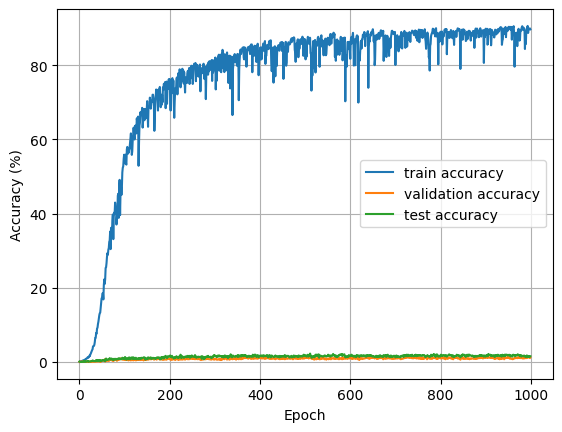

In [81]:
epoches = np.arange(num_epochs)
train_acc
plt.plot(epoches, train_acc, label="train accuracy")
plt.plot(epoches, val_acc, label="validation accuracy")
plt.plot(epoches, test_acc, label="test accuracy")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()
